# Importing libraries

In [108]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import json

# Mounting Google Drive

In [109]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
driveURL = '/content/drive/MyDrive/Neural'

# Read `newInfo.txt` file

This file has image names along with severity of growth

In [111]:
df = pd.read_csv(driveURL + '/' + 'newInfo.txt', sep = ' ')
df.head()

,IMAGE,SEVERITY
0,mdb001,B
1,mdb002,B
2,mdb003,N
3,mdb004,N
4,mdb005,B


# Set directories

In [112]:
# Directory with processed images
img_dir = driveURL + '/' + 'all-mias-no-label'

# Image names with extension
img_name = np.array(os.listdir(img_dir))

# Final image address. Used a NumPy function to evaluate
img_add = np.char.add(img_dir + '/', img_name)

In [113]:
# Testing values
img_add[2], img_name[2], len(img_name), len(img_add)

('/content/drive/MyDrive/Neural/all-mias-no-label/mdb001.jpg',
 'mdb001.jpg',
 322,
 322)

# Function to save CNN model metrics

This function will be used after training the model to save model metrics such as training/validation accuracy and training/validation loss

In [114]:
def save_dictionary(path, data):
    print('Saving catalog...')
    with open(path, 'w') as outfile:
      json.dump(str(data), fp = outfile)
    print('Catalog saved')

# Function to plot images

In [115]:
# Function to plot the image, remove the axes and give a title
# This will be called throughout the code
def plot(axes, title, img_to_plot):
    axes.axis('off')
    axes.imshow(img_to_plot, cmap = 'gray')
    axes.set_title(title)

# Print 25 random scans

In [116]:
rand_image_idx = np.random.randint(len(df), size = (5, 5))

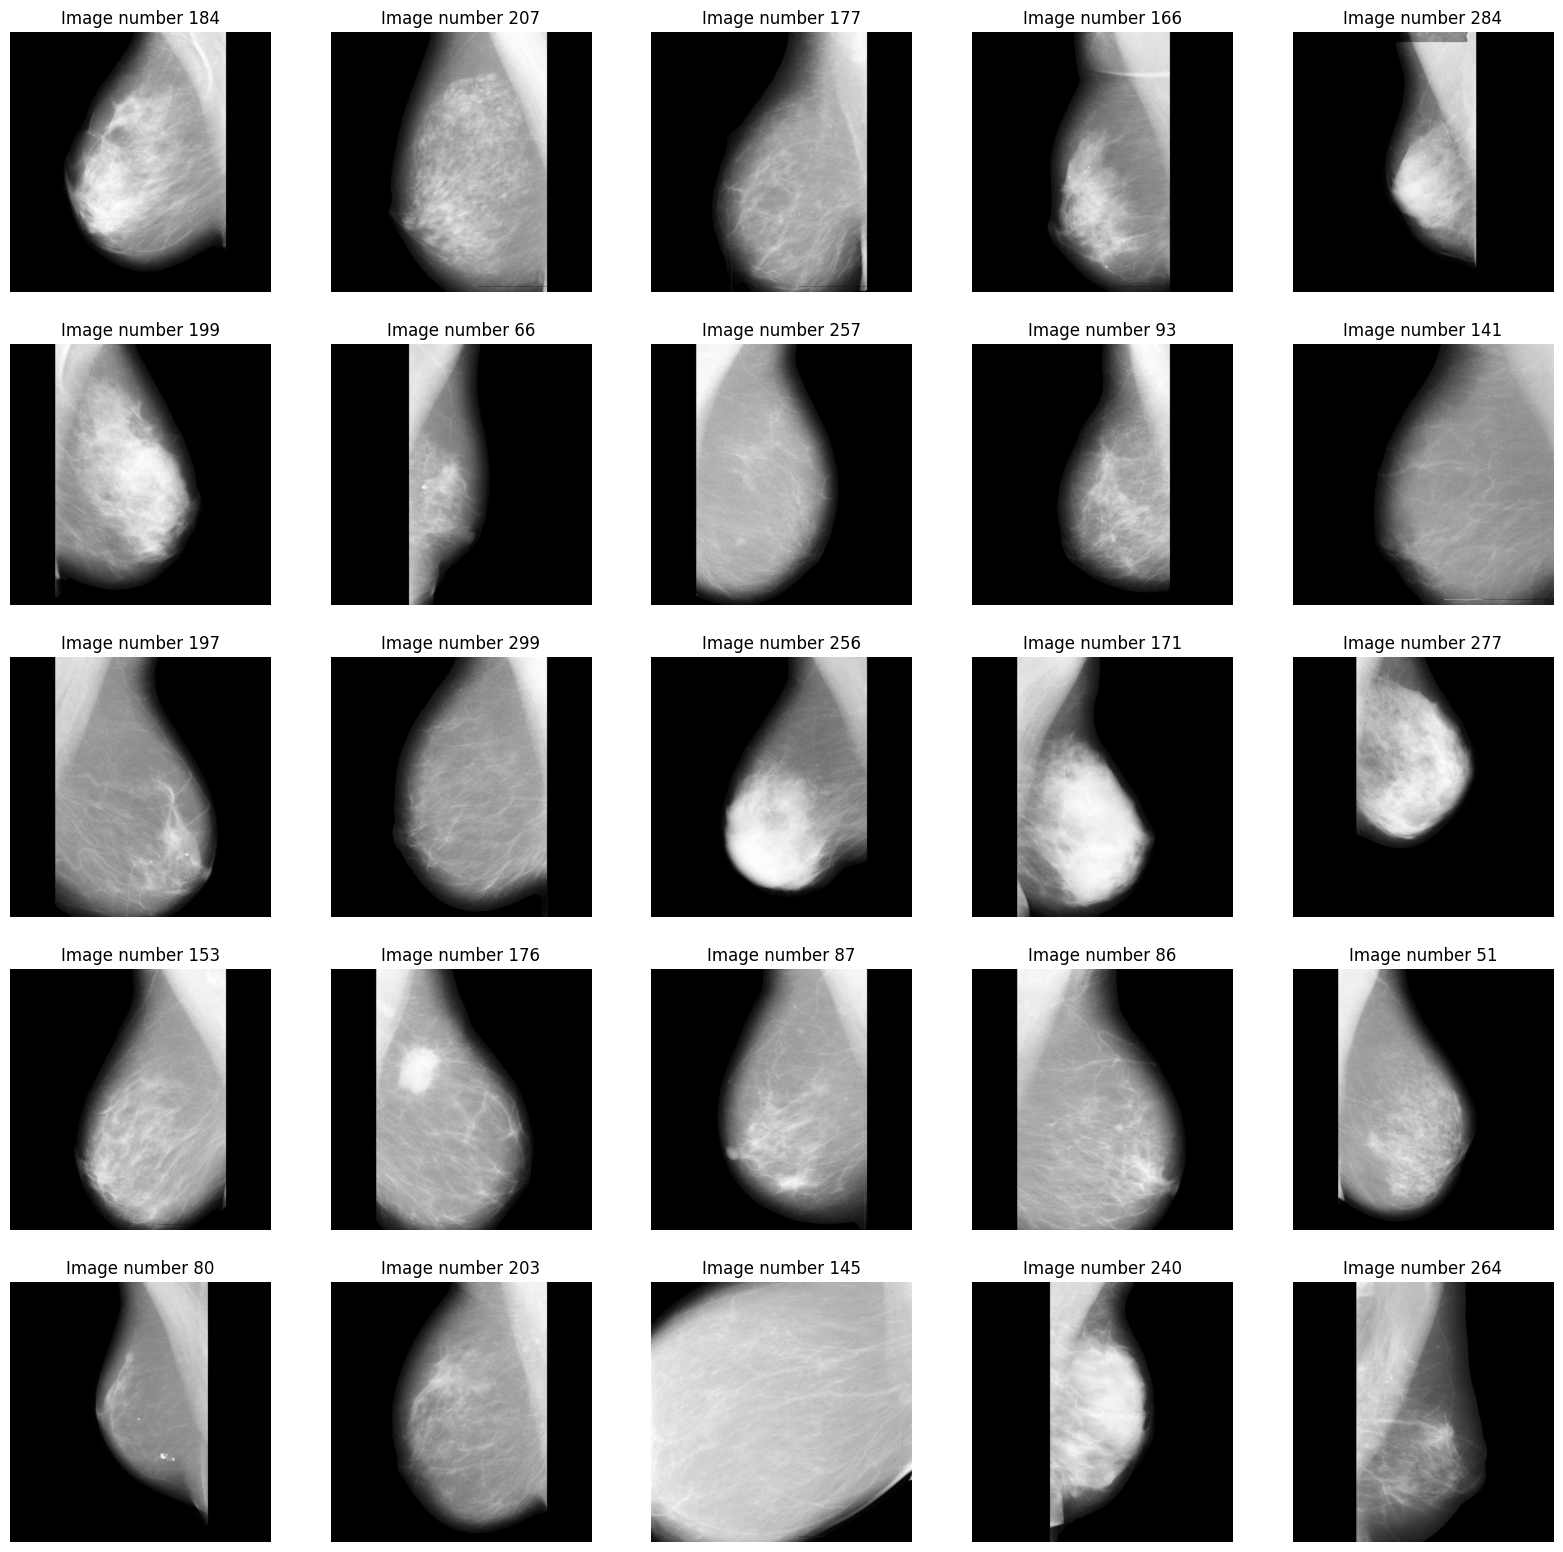

In [117]:
fig, axes = plt.subplots(nrows = 5, ncols = 5, figsize = (20, 20), dpi = 100);
currRow = 0

for i in range(5):
    for j in range(5):
        # Read the image in grayscale
        img = cv2.imread(img_add[rand_image_idx[i][j]], cv2.IMREAD_GRAYSCALE)
        
        # Plot the image
        plot(axes[i][j], f'Image number {rand_image_idx[i][j]}', img)

# Augmentation

Since deep learning models are sensitive to angles, we need to train our model for multiple angles

Steps used:
- Read image
- Normalize image
- Resize image
- Rotate image

Refer to: https://learnopencv.com/image-rotation-and-translation-using-opencv/


In [118]:
# Data augmentation
start = 0
end = 360

# Taking angle gap as 4 degrees
step = 4

In [119]:
def augmentation():
    print("Augmenting images...")
    
    # Dictionary
    info = dict()
    
    for i in range(len(df)):
        # Read image
        img = cv2.imread(img_add[i], cv2.IMREAD_GRAYSCALE)
        
        # Image name
        image_name = df['IMAGE'][i]
        
        try:
            
            # Normalise the image
            # https://stackoverflow.com/questions/50211030/normalization-method-for-convolutional-neural-network
            img = (img - img.mean()) / img.std()
            
            # Resize the image to fasten the computation time and increase accuracy(reduce noise)
            # https://www.pyimagesearch.com/2021/01/20/opencv-resize-image-cv2-resize/  
            # https://www.tutorialkart.com/opencv/python/opencv-%20python-resize-image/
            img = cv2.resize(img, dsize = (64, 64), interpolation = cv2.INTER_AREA)
            # Shape of the current image
            rows, cols = img.shape
            # Make a nested dictionary
            info[image_name] = dict()
            # Start rotating
            for angle in range(start, end, step):
                # Get rotation matrix
                rotate_matrix  = cv2.getRotationMatrix2D(center = (cols / 2, rows / 2), angle = angle, scale = 1)
                # Get rotated image
                img_rotated = cv2.warpAffine(src = img, M = rotate_matrix , dsize = (cols, rows))
                # Put the image in the dictionary with angle as the key
                info[image_name][angle] = img_rotated
        except:
            print(f'Failed for image number {i}')

    return info

In [120]:
image_info = augmentation()
print('Finished')

Augmenting images...
Finished


# Labelling

- 0 `->` No growth 
- 1 `->` Benign ; Non-cancerous
- 2 `->` Malignant ; Cancerous

In [121]:
def labelling():
    print('Labelling images...')
    
    info = {}
    
    for i in range(len(df)):
        currLabel = 0
        
        # Label
        # 0: No growth
        # 1: Benign
        # 2. Malignant
        if df['SEVERITY'][i] == 'N':
            currLabel = 0
        elif df['SEVERITY'][i] == 'B':
            currLabel = 1
        else:
            currLabel = 2
            
        info[df['IMAGE'][i]] = {}
            
        for angle in range(start, end, step):
            info[df['IMAGE'][i]][angle] = currLabel
            
    return info

In [122]:
label_info = labelling()
print('Finished')

labels = ['No growth', 'Benign ; Non-cancerous', 'Malignant ; Cancerous']

Labelling images...
Finished


# Split the data set into train and test

In [123]:
from sklearn.model_selection import train_test_split

In [124]:
ids = label_info.keys()

In [125]:
# Put image info in X and label info in Y
X = []
Y = []

for id in ids:
    
    for angle in range(start, end, step):
        X.append(image_info[id][angle])
        Y.append(label_info[id][angle])
        
X = np.array(X)
Y = np.array(Y)

In [126]:
print(f'Length of X is: {len(X)}')
print(f'Length of Y is: {len(Y)}')

Length of X is: 28980
Length of Y is: 28980


In [127]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 31)

print(f'Shape of training set: {y_train.shape[0]}')
print(f'Shape of testing set: {y_test.shape[0]}')

Shape of training set: 23184
Shape of testing set: 5796


# Reshape the images

Keras wants the data to be in `(number of images, a, b, channels)` where a and b are 2D dimensions of the images

In [128]:
# https://stackoverflow.com/questions/63279168/valueerror-input-0-of-layer-sequential-is-incompatible-with-the-layer-expect
# Keras expects (n_samples, height, width, channels) format
a, b, c = x_train.shape

x_train = x_train.reshape(a, b, c, 1)

a, b, c = x_test.shape

x_test = x_test.reshape(a, b, c, 1);

# One hot encoding the output

One hot encoding makes our training data more useful and expressive

In [129]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

In [130]:
# One hot encoding
Y_test = to_categorical(y_test)
Y_train = to_categorical(y_train)
Y_test.shape

(5796, 3)

# Define CNN model

In [131]:
# Libraries for deep learning(CNN)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras.layers import LeakyReLU

from keras import optimizers
from keras import losses
from sklearn import metrics

In [132]:
# Define the activation as leaky relu
lrelu = lambda x: tf.keras.activations.relu(x, alpha = 0.1)

In [133]:
rows, cols, color = x_train[0].shape

model = Sequential()

# For padding
# https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', input_shape = (rows, cols, 1), activation = lrelu))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = lrelu))

model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = lrelu))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = lrelu))

model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))

# Dropout layer randomly sets input units to 0 with a frequency 
# of rate at each step during training time, which helps prevent overfitting
# https://keras.io/api/layers/regularization_layers/dropout/
model.add(Dropout(0.2))

model.add(Dense(64, activation = lrelu))

model.add(Dropout(0.2))

model.add(Flatten())

# Used for multi class classification
# Normalises the 'sigmoid' results i.e. sum of probabilities will be 1
model.add(Dense(3, activation = 'softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 64)        640       
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                  

# Early stopping

Early stopping is used to prevent overfitting. We will monitor value_loss(loss on validation split) and if it's not changing much for 5 consecutive epochs, we will take the one with best weights and lowest value_loss

Refer to: https://keras.io/api/callbacks/early_stopping/

In [134]:
# Early stopping to prevent overfitting
# https://keras.io/api/callbacks/early_stopping/

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 4, restore_best_weights = True, verbose = 1)

# Training

In [135]:
# Optimizers are algorithms or methods used to change the attributes of your neural network such as weights and learning rate in order to reduce the losses
# Optimizers help to get results faster
# Adam optimizer is best for image multi class classification
# https://www.google.com/search?q=which+optimizer+to+use+for+image+multiclass+classification&rlz=1C1SQJL_enIN918IN919&sxsrf=AOaemvITXTKotxbxoQ6cLzWpcPnBngjiQQ%3A1637252286500&ei=vnyWYdPlHebXz7sP1v-doAg&oq=which+optimizer+to+use+for+image+muli&gs_lcp=Cgdnd3Mtd2l6EAMYADIHCCEQChCgATIHCCEQChCgATIHCCEQChCgAToHCAAQRxCwAzoFCAAQgAQ6BggAEBYQHjoFCCEQoAE6BgghEA0QFUoECEEYAFC8BliOF2DkHmgBcAJ4AIABhQKIAe4RkgEFMC4xLjmYAQCgAQHIAQjAAQE&sclient=gws-wiz

# For loss, we use categorical_crossentropy because our Y vector is one hot encoded
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fraction of the training data to be used as validation data. The model will not train on it, and will evaluate
# the loss and any model metrics on this data at the end of each epoch

# Batch size is the number of samples processed before the model is updated
history = model.fit(x_train, Y_train, validation_split = 0.2, epochs = 50, batch_size = 80, callbacks = [es])

Epoch 1/50
232/232 [==============================] - 29s 115ms/step - loss: 0.9032 - accuracy: 0.6425 - val_loss: 0.9050 - val_accuracy: 0.6327
Epoch 2/50
232/232 [==============================] - 25s 106ms/step - loss: 0.8896 - accuracy: 0.6446 - val_loss: 0.9068 - val_accuracy: 0.6327
Epoch 3/50
232/232 [==============================] - 25s 106ms/step - loss: 0.8784 - accuracy: 0.6444 - val_loss: 0.8911 - val_accuracy: 0.6319
Epoch 4/50
232/232 [==============================] - 25s 106ms/step - loss: 0.8667 - accuracy: 0.6439 - val_loss: 0.8792 - val_accuracy: 0.6325
Epoch 5/50
232/232 [==============================] - 25s 106ms/step - loss: 0.8504 - accuracy: 0.6466 - val_loss: 0.8586 - val_accuracy: 0.6360
Epoch 6/50
232/232 [==============================] - 25s 106ms/step - loss: 0.8233 - accuracy: 0.6547 - val_loss: 0.8358 - val_accuracy: 0.6491
Epoch 7/50
232/232 [==============================] - 25s 106ms/step - loss: 0.7823 - accuracy: 0.6661 - val_loss: 0.8005 - val_ac

# Test the model using testing dataset

In [136]:
# from keras.models import load_model
# model = load_model(driveURL + '/' + "MIAS_custom.h5", custom_objects = {'<lambda>': lrelu})

In [137]:
# Test the model
loss_value, accuracy = model.evaluate(x_test, Y_test)

print('Test loss value = ' + str(loss_value))
print('Test accuracy = ' + str(accuracy))

182/182 [==============================] - 3s 18ms/step - loss: 0.0651 - accuracy: 0.9758
Test loss value = 0.0650835782289505
Test accuracy = 0.9758453965187073


# Save model metrics in Google Drive

In [138]:
# Save the history
save_dictionary(driveURL + '/' + 'history.dat', history.history)

Saving catalog...
Catalog saved


# Plot model metrics

In [139]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

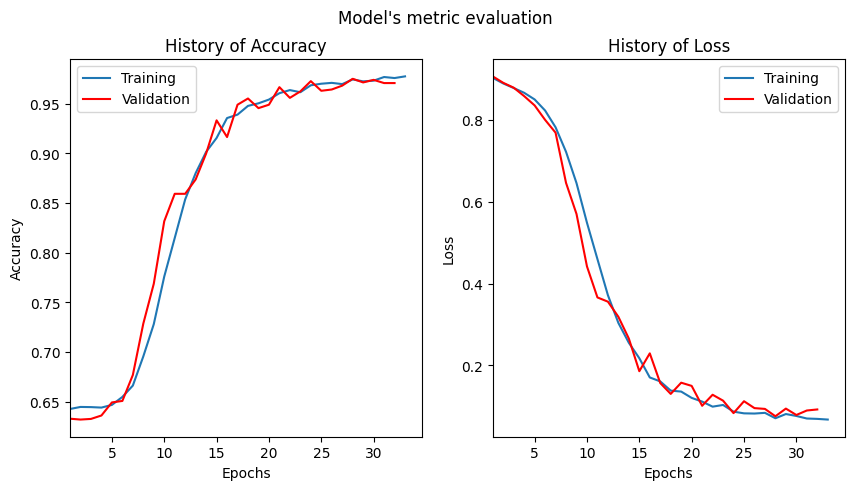

In [140]:
# Plot metrics
fig, axes = plt.subplots(1, 2, figsize = (10, 5), dpi = 100)

fig.suptitle("Model's metric evaluation")

axes[0].plot(np.arange(1, len(acc) + 1), acc, label = 'Training')
axes[0].plot(val_acc, label = 'Validation', c = 'red')
axes[0].set_xlim(1)
axes[0].set_title('History of Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(np.arange(1, len(loss) + 1), loss, label = 'Training')
axes[1].plot(val_loss, label = 'Validation', c = 'red')
axes[1].set_xlim(1)
axes[1].set_title('History of Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend();

fig.savefig(driveURL + '/' + 'metrics.jpg', bbox_inches = 'tight')

# Save the model

In [141]:
model.save(driveURL + '/' + 'MIAS_custom.h5')

# Predict the output on random but known images

In [142]:
y_pred = model.predict(x_test)

print('Shape of output from model is:', y_pred.shape, '\n')

arr = np.random.randint(len(y_pred), size = 5)

print('For random samples, below is the prediction:\n')

for idx in arr:
  print(f'Predicted output: {labels[y_pred[idx].argmax()]}\nOriginal output: {labels[Y_test[idx].argmax()]}\n')

Shape of output from model is: (5796, 3) 

For random samples, below is the prediction:

Predicted output: No growth
Original output: No growth

Predicted output: No growth
Original output: No growth

Predicted output: No growth
Original output: No growth

Predicted output: No growth
Original output: No growth

Predicted output: No growth
Original output: No growth



# Metric report on testing data

TP/FP is True/False Positive and TN/FN is True/False Negative

- Accuracy `->` $\dfrac{Total\ correct\ outcomes}{Total\ samples}$

- Precision(prediction as the base line) `->` $\dfrac{Total\ correct\ outcomes for\ class\ x}{Total\ outcomes for\ class\ x}$ or $\dfrac{TP}{TP + FP}$

- Recall(truth as the base line) `->` $\dfrac{Total\ correct\ outcomes for\ class\ x}{Total\ truth\ sample for\ class\ x}$ or $\dfrac{TP}{TP + FN}$

- F1 score(harmonic mean of precision and recall) `->` $\dfrac{2\times(precision\times recall)}{precision+ recall}$ gives overall performance of the model

- RAC AUC Score `->` An excellent model should have a score near to 1

- Cohen Kappa Score `->` Perfect models have a score between 0.81 - 1.00

In [143]:
# De one hot encoding precited output
Y_pred = []

for pred in y_pred:
  Y_pred.append(pred.argmax())

In [144]:
print('Accuracy:', np.round(metrics.accuracy_score(y_test, Y_pred), 2))
print('Precision:', np.round(metrics.precision_score(y_test, Y_pred, average = 'weighted'), 2))
print('Recall:', np.round(metrics.recall_score(y_test, Y_pred, average = 'weighted'), 2))
print('F1 Score:', np.round(metrics.f1_score(y_test, Y_pred, average = 'weighted'), 2))
print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_test, y_pred, multi_class = 'ovr', average = 'weighted'), 2))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, Y_pred), 2))

Accuracy: 0.98
Precision: 0.98
Recall: 0.98
F1 Score: 0.98
ROC AUC Score: 1.0
Cohen Kappa Score: 0.95


In [145]:
print('Classification Report:\n', metrics.classification_report(y_test, Y_pred, target_names = labels))

Classification Report:
                         precision    recall  f1-score   support

             No growth       0.98      0.99      0.98      3740
Benign ; Non-cancerous       0.98      0.96      0.97      1165
 Malignant ; Cancerous       0.97      0.94      0.96       891

              accuracy                           0.98      5796
             macro avg       0.97      0.96      0.97      5796
          weighted avg       0.98      0.98      0.98      5796

